# Useful variable gathering.
## Notes
First iteration is going to be a series of linked Lats and Longs. Don't worry too much about elevation, or make
some small if condition that might discourage going paths with too much elevation maybe.

Describe lat and longs for each point in the path.

## Import data
Import the data using CSV files.

In [2]:
import pandas as pd
df = pd.read_csv('carrauntoohil_data_set.csv')
# zip() method combines iterables into a single iterator. Output is a tuple.
points = list(zip(df['latitude'], df['longitude'], df['elevation']))

# Return the highest and lowest values from the set.
Using Pandas dataframes and the min() and max() methods to determine the lowest and highest values of the set.

In [3]:
# Return the highest and lowest values in the data set.
lowest = min(points, key=lambda x: x[2])
highest = max(points, key=lambda x: x[2])
print(lowest, highest)

(52.00236741, -9.72965549, 334.6512145996094) (51.99895007, -9.74338607, 1006.589660644531)


## Create a Graph from data points using the NetworkX Library. 

In [4]:
from scipy.spatial import KDTree
import networkx as nx

G = nx.Graph()
tree = KDTree([(lat, lon) for lat, lon, _ in points])

## Loop through the points array.
This allows the data to be iterated and stored in a series of points.
This allows assigning of indices based on neighbour values.
Adds edge weighting based on the distance of elevation between points.
There's a lot going on here, may take a few seconds to run.

In [5]:
for i, (lat, lon, elev) in enumerate(points):
    G.add_node(i, pos=(lat, lon), elevation=elev)
    distances, indices = tree.query((lat, lon), k=5)
    for j, dist in zip(indices, distances):
        if j != i:
            elev_diff = abs(elev - points[j][2])
            G.add_edge(i,j, weight=elev_diff + dist)

### Define the source and destination points and use Dijkstra's(Shortest Path First) to find shortest path.
Using the Networkx module, changing the algorithm for pathfinding is as simple as changing the name of the nx method.

#### Using Shortest Path First Algorithm
`path = nx.shortest_path(G, source=start, target=end, weight="weight")` - Shortest path using shortest path algorithm.

#### Using A* Algorithm
`path = nx.astar_path(G, source=start, target=end, weight="weight")` - Shortest path using A*.

In [6]:
start = points.index(lowest)
end = points.index(highest)
path = nx.shortest_path(G, source=start, target=end, weight="weight")
path_coords = [(df.iloc[i]['latitude'], df.iloc[i]['longitude']) for i in path]
print(path_coords)

[(np.float64(52.00236741), np.float64(-9.72965549)), (np.float64(52.00236741), np.float64(-9.72980156)), (np.float64(52.00227748), np.float64(-9.72980156)), (np.float64(52.00218755), np.float64(-9.72980156)), (np.float64(52.00209762), np.float64(-9.72980156)), (np.float64(52.00200769), np.float64(-9.72980156)), (np.float64(52.00191776), np.float64(-9.72980156)), (np.float64(52.00182783), np.float64(-9.72980156)), (np.float64(52.00173789999999), np.float64(-9.72980156)), (np.float64(52.00173789999999), np.float64(-9.72994763)), (np.float64(52.00173789999999), np.float64(-9.7300937)), (np.float64(52.00173789999999), np.float64(-9.73023977)), (np.float64(52.00173789999999), np.float64(-9.73038584)), (np.float64(52.00164797), np.float64(-9.73038584)), (np.float64(52.00164797), np.float64(-9.73053191)), (np.float64(52.00155804), np.float64(-9.73053191)), (np.float64(52.00146811), np.float64(-9.73053191)), (np.float64(52.00146811), np.float64(-9.73067798)), (np.float64(52.00137818), np.float

# Using Folium to display the completed map.

In [ ]:
import folium
# Get middle values.
mid_lat = (lowest[0] + highest[0]) / 2
mid_lon = (lowest[1] + highest[1]) / 2
m = folium.Map(location=[mid_lat, mid_lon], zoom_start=13)

# Map markers for lowest and highest points.
folium.Marker(location=[lowest[0], lowest[1]], popup="Lowest Point", icon=folium.Icon(color="green")).add_to(m)
folium.Marker(location=[highest[0], highest[1]], popup="Highest Point", icon=folium.Icon(color="red")).add_to(m)

# Add the path as a polyline to the html file.
folium.PolyLine(locations=path_coords, color="blue", weight=3, opacity=0.7).add_to(m)

# Save map to HTML file
m.save("path_map.html")

## The next box will contain a function that will change user inputs to a bounding box to gather an elevation set.

In [8]:
# This block of code will reverse Haversine to give back a distance from a point, in a direction.
from haversine import Unit, Direction, inverse_haversine
from math import sqrt

# Inverse_Haversine takes in a point, distance, direction, and unit. Note: No elevation goes in here, so if you already have it, remove it.
# This wouldn't be an issue for an end user, as they wouldn't know the elevation anyway. All they would have is a lat and long.
point = highest[0], highest[1]

def return_bounding_box(point):
    northeast_point = inverse_haversine(point, sqrt(2), Direction.NORTHEAST, Unit.KILOMETERS)
    northwest_point = inverse_haversine(point, sqrt(2), Direction.NORTHWEST, Unit.KILOMETERS)
    southeast_point = inverse_haversine(point, sqrt(2), Direction.SOUTHEAST, Unit.KILOMETERS)
    southwest_point = inverse_haversine(point, sqrt(2), Direction.SOUTHWEST, Unit.KILOMETERS)
    return northeast_point, northwest_point, southeast_point, southwest_point

print(return_bounding_box(point))

((52.0079423700814, -9.728776093542942), (52.0079423700814, -9.757996046457055), (51.989955963243716, -9.728781962457928), (51.989955963243716, -9.75799017754207))


## Next block of code will concern overlaying already existing Carrauntoohil paths on top of the ones created by the map in the second last box.

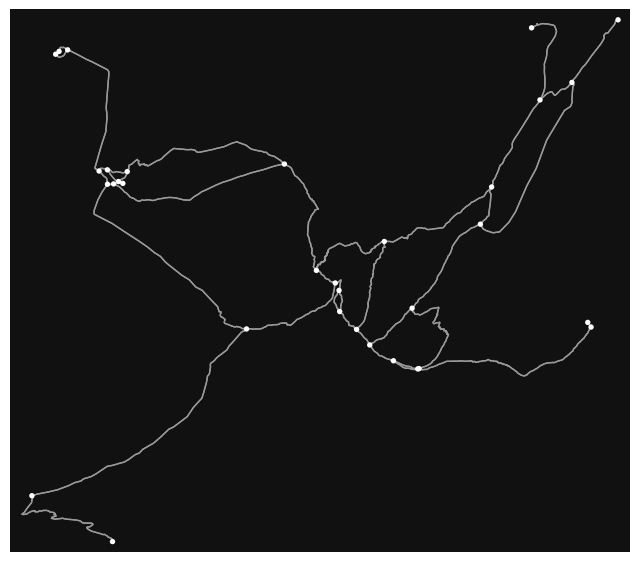

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
import osmnx as ox

# Define bounding box or center coordinate.
tags = {"highway": "path"}  # Filters for paths. OpenStreetMap uses US spelling. HiGhWaY man, dude, bro? Sidewalk, what's that aboot?

# In this case, it is the highest point.
# \env\Lib\site-packages\osmnx\convert.py
G = ox.graph_from_point((highest[0], highest[1]), dist=4000, network_type="walk", custom_filter='["highway"~"path|footway|track"]')

# Convert to GeoDataFrame
nodes, edges = ox.graph_to_gdfs(G)
# GeoJSON can be loaded into GIS programs. Don't neglect the Research section. Some of it needs gutting, and there are better areas to focus on.
edges.to_file("hiking_paths.geojson")
ox.plot_graph(G)

No direction in particular. Just need to find some way of overlaying the GeoJSON on the map.

In [10]:
# This block of code will concern overlaying a GeoJson file on the already existing map.
# The technologies that need to be accounted for are Leaflet.js, OpenStreetMap, and GeoJSON into GeoPandas maybe?
import folium
from folium import plugins

# OpenStreetMap "tiles" plugin. Lib/site-packages/folium/folium.py for Implementation.
# For a list of providers, see https://wiki.openstreetmap.org/wiki/Tile_servers
# I suppose I COULD use Google for it, I do have an API Key.
m = folium.Map(
    location=[mid_lat, mid_lon],
    tiles="OpenStreetMap",
    zoom_start=14
    )

# Add GeoJSON
folium.GeoJson(
    './hiking_paths.geojson',
    name='Mountain Paths'
).add_to(m)

folium.PolyLine(locations=path_coords, color="red", weight=3, opacity=0.7).add_to(m)

folium.LayerControl().add_to(m)

m.save('mountain_routes.html')